In [1]:
import pandas as pd
import matplotlib.pyplot as pt
import numpy as np
import os
import seaborn as sns

data = pd.read_excel('ETR-259 Findings.xlsm', sheet_name=None, index_col=False)
df = pd.concat(data.values(), sort=True, ignore_index=True)

len(df)

df = df.iloc[1:]

df.head(15)

#df = df.reset_index(drop=True)

,"D2-2029 @38bar, 800rpm, 4 L/min","D2-2042 @37bar, 800rpm, 4 L/min","D2-2050 @37bar, 800rpm, 4 L/min","D2-2062 @37bar, 800rpm, 4 L/min, Start Time: 29-Jan-2018 10:29:37","D2-2075 @38bar, 800rpm, 4 L/min, Start Time: 01-Feb-2018 09:27:55","D2-2087 @38bar, 800rpm, 4 L/min","D2-2103 @38bar, 800rpm, 4 L/min","D2_1887 @38bar, 800rpm, 4 L/min","D2_1900 @37bar, 800rpm, 4 L/min","D2_1913 @37bar, 800rpm, 4 L/min",...,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-1,NaN,NaN,...,2.8587,8.5001,-1.8356,-1.8473,4.2251,800.552,3.54,36.95,39.03,30.1019
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-2,NaN,NaN,...,2.9304,8.7309,-1.8407,-1.8474,4.1682,800.371,3.55,37.91,39.31,30.016
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-3,NaN,NaN,...,2.8644,8.6733,-1.8407,-1.8473,4.2084,800.403,3.56,37.64,39.33,30.0285
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-4,NaN,NaN,...,2.9232,8.6091,-1.8396,-1.8465,4.2849,800.371,3.54,38.04,39.48,30.085
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-5,NaN,NaN,...,2.9157,7.9299,-1.8411,-1.8469,4.1698,800.312,3.57,38.78,39.93,30.1244
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-6,NaN,NaN,...,2.8515,7.9395,-1.8319,-1.8441,4.1945,800.251,3.59,38.97,39.77,30.1477
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Average,NaN,NaN,...,2.89065,8.39713,-1.83827,-1.84658,4.20848,800.377,3.55833,38.0483,39.475,30.0839
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Std Dev,NaN,NaN,...,0.032938,0.3344,0.0033984,0.0011524,0.039645,0.092385,0.017717,0.68033,0.3001,0.047811
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"D2_1888 @30bar, 800rpm, 4 L/min",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Data ref,NaN,NaN,...,"Mean RoPR (cyl 1), bar/deg","Max RoPR (cyl 1), bar/deg","Max Crank Case Pressure, (deg aTDC)","Min Crank Case Pressure, (deg aTDC)",HEF flow (l/min),Engine speed (rpm),HS_TransPower (kW),BSFC_Trans_Thermal (Wh/kg),BSFC_Trans_Coriolis (Wh/kg),"T, N2 Inlet(degC)"


In [2]:
df.columns = df.iloc[9,:]
df.head()

10,nan,nan,nan,nan,nan,nan,nan,Data ref,nan,nan,...,"Mean RoPR (cyl 1), bar/deg","Max RoPR (cyl 1), bar/deg","Max Crank Case Pressure, (deg aTDC)","Min Crank Case Pressure, (deg aTDC)",HEF flow (l/min),Engine speed (rpm),HS_TransPower (kW),BSFC_Trans_Thermal (Wh/kg),BSFC_Trans_Coriolis (Wh/kg),"T, N2 Inlet(degC)"
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-1,NaN,NaN,...,2.8587,8.5001,-1.8356,-1.8473,4.2251,800.552,3.54,36.95,39.03,30.1019
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-2,NaN,NaN,...,2.9304,8.7309,-1.8407,-1.8474,4.1682,800.371,3.55,37.91,39.31,30.016
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-3,NaN,NaN,...,2.8644,8.6733,-1.8407,-1.8473,4.2084,800.403,3.56,37.64,39.33,30.0285
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-4,NaN,NaN,...,2.9232,8.6091,-1.8396,-1.8465,4.2849,800.371,3.54,38.04,39.48,30.085
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-5,NaN,NaN,...,2.9157,7.9299,-1.8411,-1.8469,4.1698,800.312,3.57,38.78,39.93,30.1244


In [3]:
average = df[df.values == "Average"]
std = df[df.values == "Std Dev"]
dataRef = df[df.values =="Data ref"]

average_list = average.index
std_list = std.index
dataRef_list = dataRef.index

df = df.drop(index = average_list)
df = df.drop(index = std_list)
df = df.drop(index = dataRef_list)

df = df.reset_index(drop=True)
df.head(15)

10,nan,nan,nan,nan,nan,nan,nan,Data ref,nan,nan,...,"Mean RoPR (cyl 1), bar/deg","Max RoPR (cyl 1), bar/deg","Max Crank Case Pressure, (deg aTDC)","Min Crank Case Pressure, (deg aTDC)",HEF flow (l/min),Engine speed (rpm),HS_TransPower (kW),BSFC_Trans_Thermal (Wh/kg),BSFC_Trans_Coriolis (Wh/kg),"T, N2 Inlet(degC)"
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-1,NaN,NaN,...,2.8587,8.5001,-1.8356,-1.8473,4.2251,800.552,3.54,36.95,39.03,30.1019
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-2,NaN,NaN,...,2.9304,8.7309,-1.8407,-1.8474,4.1682,800.371,3.55,37.91,39.31,30.016
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-3,NaN,NaN,...,2.8644,8.6733,-1.8407,-1.8473,4.2084,800.403,3.56,37.64,39.33,30.0285
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-4,NaN,NaN,...,2.9232,8.6091,-1.8396,-1.8465,4.2849,800.371,3.54,38.04,39.48,30.085
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-5,NaN,NaN,...,2.9157,7.9299,-1.8411,-1.8469,4.1698,800.312,3.57,38.78,39.93,30.1244
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-6,NaN,NaN,...,2.8515,7.9395,-1.8319,-1.8441,4.1945,800.251,3.59,38.97,39.77,30.1477
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"D2_1888 @30bar, 800rpm, 4 L/min",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1888-1,NaN,NaN,...,2.3328,6.2968,-1.8373,-1.8423,4.1676,800.226,2.69,36.97,37.77,29.9628
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1888-2,NaN,NaN,...,2.3463,6.521,-1.8324,-1.8406,4.2017,800.193,2.66,36.5,37.35,30.0285
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1888-3,NaN,NaN,...,2.3345,6.4648,-1.8329,-1.8377,4.1746,800.238,2.65,36.64,37.56,30.1082


In [4]:
df.columns

Index([                                  nan,
                                         nan,
                                         nan,
                                         nan,
                                         nan,
                                         nan,
                                         nan,
                                  'Data ref',
                                         nan,
                                         nan,
                                         nan,
                                         nan,
                                         nan,
                                         nan,
                                         nan,
                                         nan,
                                         nan,
                                         nan,
                               'P, N2 (bar)',
                        'T, HEF Inlet(degC)',
                         'T, HEF Out (degC)',
                         'T, Exhau

In [5]:
df["DataRef"] = np.nan
for i in range(1,19):
    df["DataRef"] = df["DataRef"].fillna(df.iloc[:,i])
    
df.head(20)

10,nan,nan,nan,nan,nan,nan,nan,Data ref,nan,nan,...,"Max RoPR (cyl 1), bar/deg","Max Crank Case Pressure, (deg aTDC)","Min Crank Case Pressure, (deg aTDC)",HEF flow (l/min),Engine speed (rpm),HS_TransPower (kW),BSFC_Trans_Thermal (Wh/kg),BSFC_Trans_Coriolis (Wh/kg),"T, N2 Inlet(degC)",DataRef
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-1,NaN,NaN,...,8.5001,-1.8356,-1.8473,4.2251,800.552,3.54,36.95,39.03,30.1019,D2-1887-1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-2,NaN,NaN,...,8.7309,-1.8407,-1.8474,4.1682,800.371,3.55,37.91,39.31,30.016,D2-1887-2
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-3,NaN,NaN,...,8.6733,-1.8407,-1.8473,4.2084,800.403,3.56,37.64,39.33,30.0285,D2-1887-3
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-4,NaN,NaN,...,8.6091,-1.8396,-1.8465,4.2849,800.371,3.54,38.04,39.48,30.085,D2-1887-4
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-5,NaN,NaN,...,7.9299,-1.8411,-1.8469,4.1698,800.312,3.57,38.78,39.93,30.1244,D2-1887-5
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1887-6,NaN,NaN,...,7.9395,-1.8319,-1.8441,4.1945,800.251,3.59,38.97,39.77,30.1477,D2-1887-6
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"D2_1888 @30bar, 800rpm, 4 L/min",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"D2_1888 @30bar, 800rpm, 4 L/min"
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1888-1,NaN,NaN,...,6.2968,-1.8373,-1.8423,4.1676,800.226,2.69,36.97,37.77,29.9628,D2-1888-1
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1888-2,NaN,NaN,...,6.521,-1.8324,-1.8406,4.2017,800.193,2.66,36.5,37.35,30.0285,D2-1888-2
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2-1888-3,NaN,NaN,...,6.4648,-1.8329,-1.8377,4.1746,800.238,2.65,36.64,37.56,30.1082,D2-1888-3


In [6]:
df = df.iloc[:,18:]
df.head()

10,"P, N2 (bar)","T, HEF Inlet(degC)","T, HEF Out (degC)","T, Exhaust (degC)",HS_TransTorque (Nm),LS_TransTorque (Nm),HS_DynoPower (kW),HS_DynoTorque (Nm),"Pi, (kW)","Pf, (kW)",...,"Max RoPR (cyl 1), bar/deg","Max Crank Case Pressure, (deg aTDC)","Min Crank Case Pressure, (deg aTDC)",HEF flow (l/min),Engine speed (rpm),HS_TransPower (kW),BSFC_Trans_Thermal (Wh/kg),BSFC_Trans_Coriolis (Wh/kg),"T, N2 Inlet(degC)",DataRef
0,37.6109,30.2634,400,10.9853,42.217,40.2484,3.33,39.7802,4.3816,0.8424,...,8.5001,-1.8356,-1.8473,4.2251,800.552,3.54,36.95,39.03,30.1019,D2-1887-1
1,37.5765,29.9824,400,11.4807,42.4046,40.8654,3.36,40.1055,4.3411,0.78693,...,8.7309,-1.8407,-1.8474,4.1682,800.371,3.55,37.91,39.31,30.016,D2-1887-2
2,37.704,29.987,400,11.4858,42.4157,47.1664,3.35,39.9211,4.3465,0.79126,...,8.6733,-1.8407,-1.8473,4.2084,800.403,3.56,37.64,39.33,30.0285,D2-1887-3
3,37.7029,29.8452,400,11.5008,42.2726,35.572,3.34,39.7943,4.3293,0.78627,...,8.6091,-1.8396,-1.8465,4.2849,800.371,3.54,38.04,39.48,30.085,D2-1887-4
4,37.4003,29.9082,400,11.2926,42.6383,40.7389,3.38,40.2839,4.3622,0.78872,...,7.9299,-1.8411,-1.8469,4.1698,800.312,3.57,38.78,39.93,30.1244,D2-1887-5


In [7]:
df.dropna(axis = 0, inplace=True)

In [8]:
df.head(15)

10,"P, N2 (bar)","T, HEF Inlet(degC)","T, HEF Out (degC)","T, Exhaust (degC)",HS_TransTorque (Nm),LS_TransTorque (Nm),HS_DynoPower (kW),HS_DynoTorque (Nm),"Pi, (kW)","Pf, (kW)",...,"Max RoPR (cyl 1), bar/deg","Max Crank Case Pressure, (deg aTDC)","Min Crank Case Pressure, (deg aTDC)",HEF flow (l/min),Engine speed (rpm),HS_TransPower (kW),BSFC_Trans_Thermal (Wh/kg),BSFC_Trans_Coriolis (Wh/kg),"T, N2 Inlet(degC)",DataRef
0,37.6109,30.2634,400,10.9853,42.217,40.2484,3.33,39.7802,4.3816,0.8424,...,8.5001,-1.8356,-1.8473,4.2251,800.552,3.54,36.95,39.03,30.1019,D2-1887-1
1,37.5765,29.9824,400,11.4807,42.4046,40.8654,3.36,40.1055,4.3411,0.78693,...,8.7309,-1.8407,-1.8474,4.1682,800.371,3.55,37.91,39.31,30.016,D2-1887-2
2,37.704,29.987,400,11.4858,42.4157,47.1664,3.35,39.9211,4.3465,0.79126,...,8.6733,-1.8407,-1.8473,4.2084,800.403,3.56,37.64,39.33,30.0285,D2-1887-3
3,37.7029,29.8452,400,11.5008,42.2726,35.572,3.34,39.7943,4.3293,0.78627,...,8.6091,-1.8396,-1.8465,4.2849,800.371,3.54,38.04,39.48,30.085,D2-1887-4
4,37.4003,29.9082,400,11.2926,42.6383,40.7389,3.38,40.2839,4.3622,0.78872,...,7.9299,-1.8411,-1.8469,4.1698,800.312,3.57,38.78,39.93,30.1244,D2-1887-5
5,37.5768,30.2007,400,11.9716,42.8483,41.0642,3.4,40.5404,4.3812,0.79037,...,7.9395,-1.8319,-1.8441,4.1945,800.251,3.59,38.97,39.77,30.1477,D2-1887-6
7,29.7603,29.9371,400,12.9962,32.0833,32.4087,2.55,30.376,3.3549,0.66629,...,6.2968,-1.8373,-1.8423,4.1676,800.226,2.69,36.97,37.77,29.9628,D2-1888-1
8,29.7603,29.9625,400,12.9372,31.7096,32.6196,2.51,29.9424,3.3485,0.69134,...,6.521,-1.8324,-1.8406,4.2017,800.193,2.66,36.5,37.35,30.0285,D2-1888-2
9,29.8763,29.8876,400,12.7973,31.5917,31.6178,2.48,29.6476,3.3379,0.69053,...,6.4648,-1.8329,-1.8377,4.1746,800.238,2.65,36.64,37.56,30.1082,D2-1888-3
10,30.1233,30.0585,400,13.6568,31.9629,35.4269,2.52,30.0775,3.3613,0.68283,...,6.1392,-1.8416,-1.8464,4.1786,800.217,2.68,37.02,37.78,29.9739,D2-1888-4


In [9]:
df = df.apply(lambda x: pd.to_numeric(x, errors = 'coerce')).dropna();

In [10]:
df.drop(['Pcyl 1 @ BDC', 'SOI (cyl 1), CA aTDC', 'Pi, (kW)', 'Pf, (kW)',
       'Pp, (kW)', 'k1 (0% HEF)',
       'k1 (50% HEF)', 'k1 (100% HEF)', 'Mechanical efficiency', 'T, HEF Out (degC)','T, Oil (degC)','Pmax (cyl 1)','DataRef'], axis = 1, inplace=True);

In [11]:
df.columns

Index(['P, N2 (bar)', 'T, HEF Inlet(degC)', 'T, Exhaust (degC)',
       'HS_TransTorque (Nm)', 'LS_TransTorque (Nm)', 'HS_DynoPower (kW)',
       'HS_DynoTorque (Nm)', 'N2 MassFlow Coriolis (kg/min)', 'IMEP total',
       'BMEP total', 'FMEP total', 'PMEP total', 'P, Exhaust (bar)',
       'P, Oil (bar)', 'N2 MassFlow Thermal (kg/min)', 'Angle Pmax (cyl 1)',
       'Mean RoPR (cyl 1), bar/deg', 'Max RoPR (cyl 1), bar/deg',
       'Max Crank Case Pressure, (deg aTDC)',
       'Min Crank Case Pressure, (deg aTDC)', 'HEF flow (l/min)',
       'Engine speed (rpm)', 'HS_TransPower (kW)',
       'BSFC_Trans_Thermal (Wh/kg)', 'BSFC_Trans_Coriolis (Wh/kg)',
       'T, N2 Inlet(degC)'],
      dtype='object', name=10)

In [12]:
df.describe()

10,"P, N2 (bar)","T, HEF Inlet(degC)","T, Exhaust (degC)",HS_TransTorque (Nm),LS_TransTorque (Nm),HS_DynoPower (kW),HS_DynoTorque (Nm),N2 MassFlow Coriolis (kg/min),IMEP total,BMEP total,...,"Mean RoPR (cyl 1), bar/deg","Max RoPR (cyl 1), bar/deg","Max Crank Case Pressure, (deg aTDC)","Min Crank Case Pressure, (deg aTDC)",HEF flow (l/min),Engine speed (rpm),HS_TransPower (kW),BSFC_Trans_Thermal (Wh/kg),BSFC_Trans_Coriolis (Wh/kg),"T, N2 Inlet(degC)"
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,37.657793,19.861140,4.454524,41.129513,40.510395,3.669273,39.318169,1.612393,6.708633,5.402180,...,2.644018,7.253878,-1.835582,-1.847242,4.581153,893.009131,3.838182,39.008364,39.515273,30.038667
std,5.330118,0.185783,2.025538,7.596039,11.276062,0.733790,7.482343,0.274022,1.111649,1.503632,...,0.376302,1.284565,0.041133,0.002560,0.393125,79.899608,0.744571,1.397489,1.361110,0.131004
min,29.866600,19.490800,1.087200,29.199000,15.488400,2.540000,27.249500,1.173800,5.034400,2.064100,...,1.937200,5.262600,-1.843300,-1.854400,4.094500,799.658600,2.680000,36.370000,36.860000,29.833000
25%,37.261750,19.714050,3.168200,38.916550,32.057500,3.440000,37.173050,1.482300,6.452000,4.274900,...,2.489150,6.447900,-1.842000,-1.847650,4.182500,810.720850,3.590000,38.140000,38.830000,29.942100
50%,37.483300,19.866500,4.385700,40.298900,41.352000,3.620000,38.495900,1.601900,6.590900,5.517600,...,2.612500,6.972800,-1.841300,-1.847000,4.605200,900.225800,3.790000,39.050000,39.600000,30.041500
75%,41.443150,19.992950,5.852300,46.209700,44.878150,4.145000,44.453000,1.768750,7.488550,5.988800,...,2.944700,7.895400,-1.840350,-1.846300,5.085150,999.693400,4.305000,40.020000,40.430000,30.104600
max,45.250100,20.224100,7.854900,54.838200,70.803700,5.010000,52.630900,2.147700,8.622400,9.435900,...,3.304400,10.479800,-1.536300,-1.834800,5.137000,999.786600,5.200000,41.590000,42.160000,30.513800


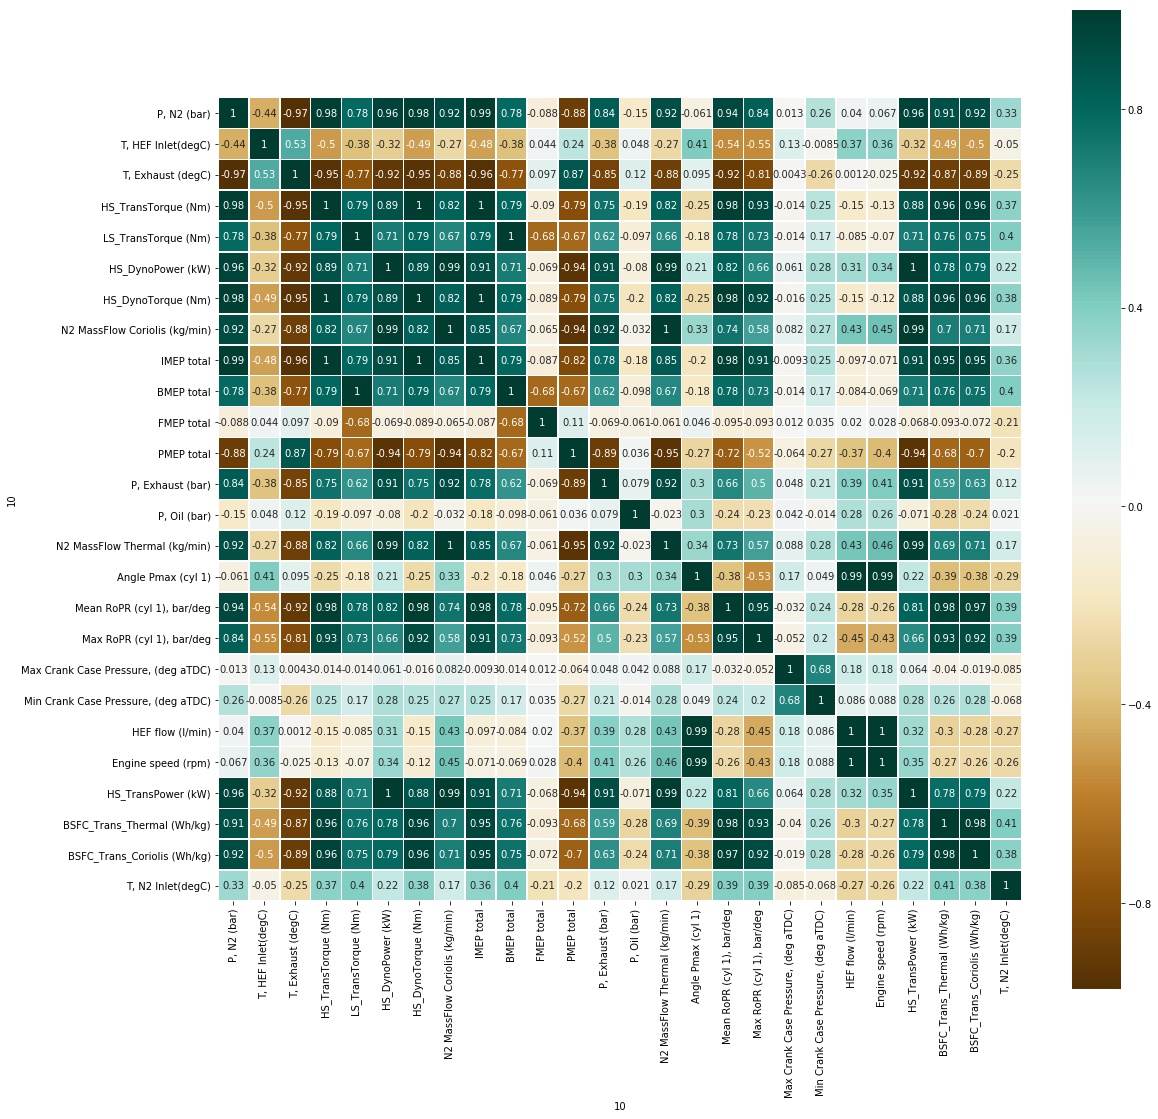

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
plot = plt.figure(figsize = (18,18))
sns.heatmap(df.corr(), annot=True, linewidths=0.5, cmap="BrBG", square=True)

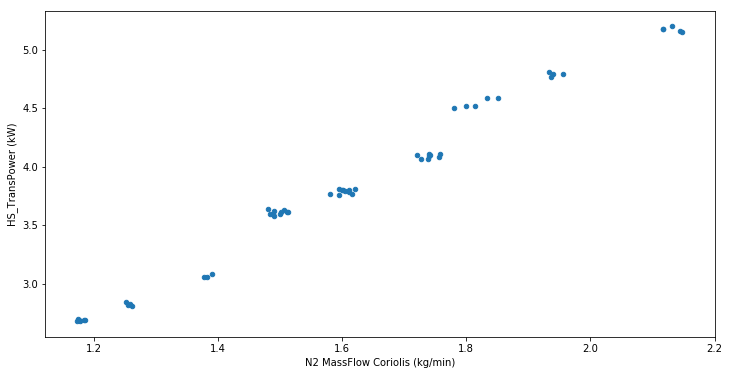

In [14]:
df.plot.scatter(x = 'N2 MassFlow Coriolis (kg/min)', y = 'HS_TransPower (kW)', figsize = (12,6))

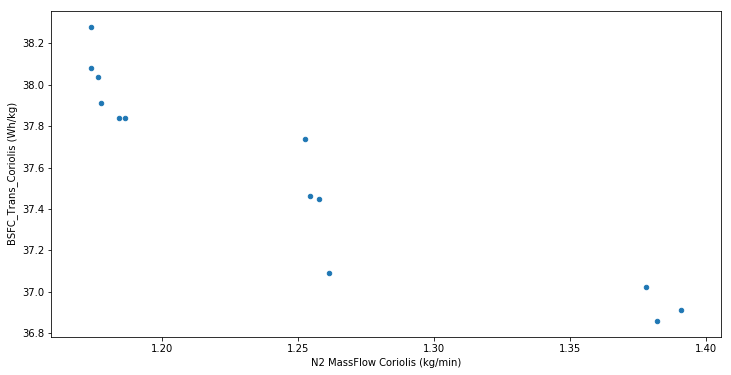

In [15]:
df[df['P, N2 (bar)'] < 35].plot.scatter(x = 'N2 MassFlow Coriolis (kg/min)', y = 'BSFC_Trans_Coriolis (Wh/kg)', figsize=(12,6))

## Graph above shows that the Power output increases with increasing N2 mass flow and that it is linear. So linear model could be used.
### Interestingly the flow rate is independent of RPM and N2 pressure

In [16]:
df.head()

10,"P, N2 (bar)","T, HEF Inlet(degC)","T, Exhaust (degC)",HS_TransTorque (Nm),LS_TransTorque (Nm),HS_DynoPower (kW),HS_DynoTorque (Nm),N2 MassFlow Coriolis (kg/min),IMEP total,BMEP total,...,"Mean RoPR (cyl 1), bar/deg","Max RoPR (cyl 1), bar/deg","Max Crank Case Pressure, (deg aTDC)","Min Crank Case Pressure, (deg aTDC)",HEF flow (l/min),Engine speed (rpm),HS_TransPower (kW),BSFC_Trans_Thermal (Wh/kg),BSFC_Trans_Coriolis (Wh/kg),"T, N2 Inlet(degC)"
758,37.6253,19.7286,4.1485,42.8428,42.1422,3.48,40.9604,1.4800,6.8786,5.6240,...,2.7938,7.5903,-1.8413,-1.8464,4.1865,810.7627,3.64,40.12,40.96,29.8701
759,37.4980,19.5974,4.3250,42.7838,42.0526,3.46,40.7794,1.5060,6.8727,5.6124,...,2.7484,8.5094,-1.8409,-1.8472,4.1800,810.7714,3.63,40.03,40.20,29.9052
760,37.5292,19.6379,4.3081,42.1557,41.3520,3.42,40.2533,1.4903,6.8260,5.5176,...,2.7814,7.6888,-1.8411,-1.8467,4.1828,810.7797,3.58,39.73,40.03,30.0234
761,37.6152,19.6901,4.3698,42.5706,41.8633,3.46,40.7016,1.5137,6.8618,5.5875,...,2.8382,7.6333,-1.8414,-1.8473,4.1810,810.7761,3.61,39.48,39.80,29.9729
762,37.7293,19.6716,4.0988,42.5119,41.7315,3.46,40.7155,1.5111,6.8715,5.5699,...,2.9145,7.6490,-1.8413,-1.8469,4.1696,810.7848,3.61,39.45,39.81,29.9607


## The columns I want to keep
* Power
* BSFC
* N2 pressure
* N2 flow
* T, HEF
* Engine Speed

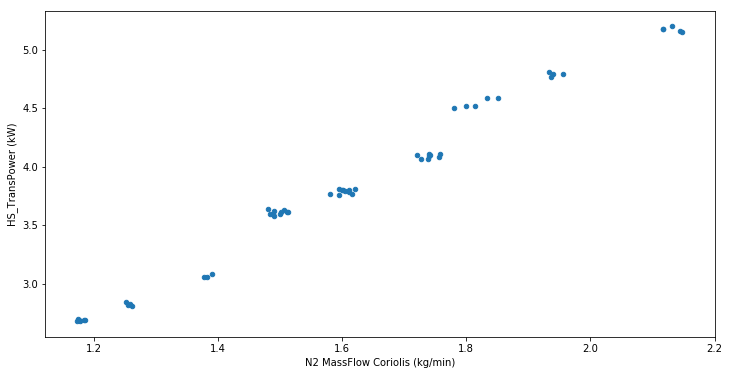

In [17]:
df.plot.scatter(x = 'N2 MassFlow Coriolis (kg/min)', y = 'HS_TransPower (kW)', figsize = (12,6))

In [18]:
df.columns

Index(['P, N2 (bar)', 'T, HEF Inlet(degC)', 'T, Exhaust (degC)',
       'HS_TransTorque (Nm)', 'LS_TransTorque (Nm)', 'HS_DynoPower (kW)',
       'HS_DynoTorque (Nm)', 'N2 MassFlow Coriolis (kg/min)', 'IMEP total',
       'BMEP total', 'FMEP total', 'PMEP total', 'P, Exhaust (bar)',
       'P, Oil (bar)', 'N2 MassFlow Thermal (kg/min)', 'Angle Pmax (cyl 1)',
       'Mean RoPR (cyl 1), bar/deg', 'Max RoPR (cyl 1), bar/deg',
       'Max Crank Case Pressure, (deg aTDC)',
       'Min Crank Case Pressure, (deg aTDC)', 'HEF flow (l/min)',
       'Engine speed (rpm)', 'HS_TransPower (kW)',
       'BSFC_Trans_Thermal (Wh/kg)', 'BSFC_Trans_Coriolis (Wh/kg)',
       'T, N2 Inlet(degC)'],
      dtype='object', name=10)

In [19]:
df_filtered = df.filter(['P, N2 (bar)', 'BSFC_Trans_Coriolis (Wh/kg)','N2 MassFlow Thermal (kg/min)','T, HEF Inlet(degC)','Engine speed (rpm)','HS_TransPower (kW)','BSFC_Trans_Thermal (Wh/kg)'], axis =1)
df_filtered.head()

10,"P, N2 (bar)",BSFC_Trans_Coriolis (Wh/kg),N2 MassFlow Thermal (kg/min),"T, HEF Inlet(degC)",Engine speed (rpm),HS_TransPower (kW),BSFC_Trans_Thermal (Wh/kg)
758,37.6253,40.96,1.5112,19.7286,810.7627,3.64,40.12
759,37.4980,40.20,1.5125,19.5974,810.7714,3.63,40.03
760,37.5292,40.03,1.5013,19.6379,810.7797,3.58,39.73
761,37.6152,39.80,1.5259,19.6901,810.7761,3.61,39.48
762,37.7293,39.81,1.5249,19.6716,810.7848,3.61,39.45


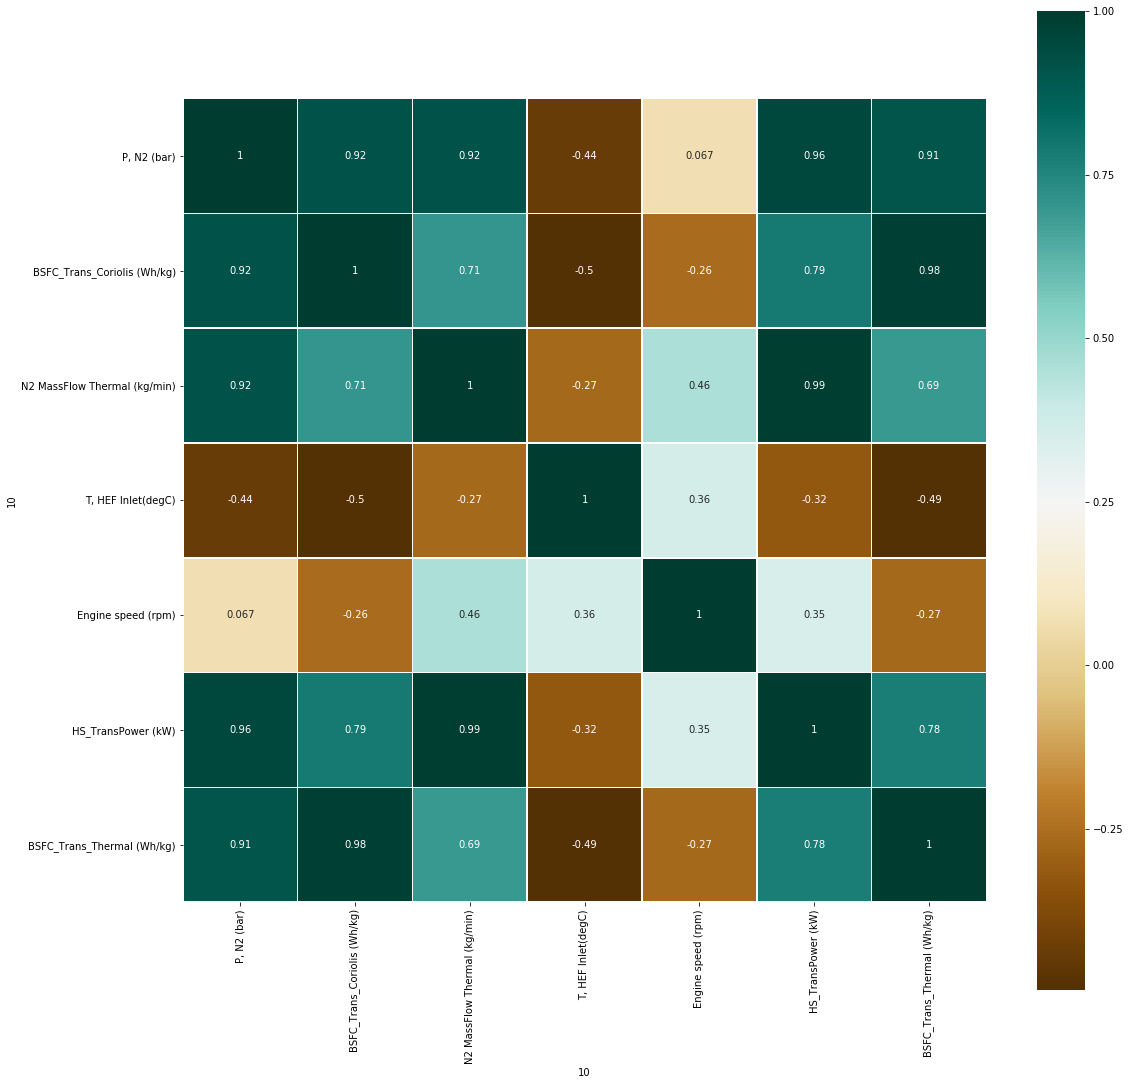

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plot = plt.figure(figsize = (18,18))
sns.heatmap(df_filtered.corr(), annot=True, linewidths=0.5, cmap="BrBG", square=True)

In [21]:
df_filtered.isnull().sum()

10
P, N2 (bar)                     0
BSFC_Trans_Coriolis (Wh/kg)     0
N2 MassFlow Thermal (kg/min)    0
T, HEF Inlet(degC)              0
Engine speed (rpm)              0
HS_TransPower (kW)              0
BSFC_Trans_Thermal (Wh/kg)      0
dtype: int64

In [22]:
indices = range(len(df_filtered))
train = [indices[i] for i in indices if i%3 !=0]
test = [indices[i] for i in indices if i%3 ==0]
test_df = df_filtered.iloc[test]
train_df =df_filtered.iloc[train]

In [23]:
train_df.columns

Index(['P, N2 (bar)', 'BSFC_Trans_Coriolis (Wh/kg)',
       'N2 MassFlow Thermal (kg/min)', 'T, HEF Inlet(degC)',
       'Engine speed (rpm)', 'HS_TransPower (kW)',
       'BSFC_Trans_Thermal (Wh/kg)'],
      dtype='object', name=10)

In [24]:
test_df.loc[len(test_df)] = [0,0,0,0,0,8,0] 
test_df

C:\Users\jan.santora\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


10,"P, N2 (bar)",BSFC_Trans_Coriolis (Wh/kg),N2 MassFlow Thermal (kg/min),"T, HEF Inlet(degC)",Engine speed (rpm),HS_TransPower (kW),BSFC_Trans_Thermal (Wh/kg)
758,37.6253,40.96,1.5112,19.7286,810.7627,3.64,40.12
761,37.6152,39.80,1.5259,19.6901,810.7761,3.61,39.48
765,29.9334,37.84,1.2001,19.9768,810.7316,2.69,37.33
768,29.9674,38.04,1.1892,19.8305,810.7070,2.69,37.63
772,45.1930,41.73,1.8416,19.6039,799.6697,4.59,41.56
775,45.1056,41.53,1.8298,19.7913,799.7155,4.52,41.18
779,37.6415,40.02,1.5095,19.9955,799.6839,3.60,39.77
783,37.3498,39.13,1.6625,19.4908,900.2538,3.78,37.94
786,37.3915,39.15,1.6427,19.8247,900.2170,3.81,38.64
790,30.0985,37.45,1.2771,19.8577,900.2179,2.83,36.88


In [25]:
from sklearn.linear_model import LinearRegression

x_train = train_df.drop(["N2 MassFlow Thermal (kg/min)", "BSFC_Trans_Coriolis (Wh/kg)"], axis =1)
y_train = train_df["N2 MassFlow Thermal (kg/min)"]
x_test = test_df.drop(["N2 MassFlow Thermal (kg/min)", "BSFC_Trans_Coriolis (Wh/kg)"], axis=1)
x_train.shape, y_train.shape, x_test.shape

((36, 5), (36,), (20, 5))

In [30]:
lr = LinearRegression()
lr.fit(x_train, y_train)
Y_pred = lr.predict(x_test)

difference = 100*(((Y_pred)-test_df["N2 MassFlow Thermal (kg/min)"])/(Y_pred))

predicted_power = pd.DataFrame({
        "HEF Temp. [°C]": test_df["T, HEF Inlet(degC)"],
        "Engine Speed [RPM]": test_df["Engine speed (rpm)"],
        "N2 Pressure [barg]": test_df["P, N2 (bar)"],
        #"BSFC [Wh/kg]": test_df["BSFC_Trans_Coriolis (Wh/kg)"],
        "Break Power [W]":test_df["HS_TransPower (kW)"],
        "N2 MassFlow Thermal (kg/min)": test_df["N2 MassFlow Thermal (kg/min)"],
        "N2 MassFlow Thermal (kg/min)_predicted":Y_pred,
        "Difference": difference
    })

predicted_power.to_csv('LinearRegression.csv', index=False)
print("The maximum percentage difference is:", difference.max())
print ("The min percentage difference is:", difference.min())
predicted_power.to_csv('N2FlowPredicted.csv')


The maximum percentage difference is: 100.0
The min percentage difference is: -1.050033727036102


In [31]:
class style:
    BOLD = '\033[1m'
    END = '\033[0m'

In [38]:
print (style.BOLD + "The N2 flow rate to achieve 8kw Power output is predicted to be"+ style.END, predicted_power["N2 MassFlow Thermal (kg/min)_predicted"].max())

The N2 flow rate to achieve 8kw Power output is predicted to be 3.9597116387045492


In [39]:
print ("The N2 flow rate to achieve 8kw Power output is predicted to be", predicted_power["N2 MassFlow Thermal (kg/min)_predicted"].max())

The N2 flow rate to achieve 8kw Power output is predicted to be 3.9597116387045492
